In [1]:
import pandas as pd
import numpy as np 
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.pyplot import imshow
import math
import sys
%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)
from collections import Counter
import scipy
import cv2

In [54]:
def get_key(dictionary, value):
    for k,v in dictionary.items():
        if v == value:
            return k
        
def count_zero(array):
    i = 0
    for element in array:
        if element == 0:
            i+=1
        else:
            break
    return i        
        
def image_to_cv(image):
    image = Image.open(image)
    a = np.asarray(image)
    a = a.astype('float32')
    a = a/(np.amax(a))
    a = a*255
    a = a.astype('uint8')
    a = cv2.cvtColor(a, cv2.COLOR_GRAY2BGR)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2HSV)
    a = cv2.cvtColor(a, cv2.COLOR_RGB2GRAY)
    return a

def got_x(array):
    i = 0
    for element in array:
        if element == 0:
            i+=1
            continue
        else:
            i+=1
            break
    return i

def got_y(array):
    i = 0
    for element in array:
        if np.nanmax(element)==0:
            i+=1
            continue
        else:
            i+=1
            break
    return i

def got_low_y(array):
    i = 0
    for element in reversed(array):
        if np.nanmax(element)==0:
            i+=1
            continue
        else:
            i+=1
            break
    return i

def len_segment(x1,y1,x2,y2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2)

def lin_ur(x1,y1,x2,y2):
    return (y1-y2),(x2-x1),(x1*y2-x2*y1) 

def cross_point(x1,y1,x2,y2,n1,n2):
    m1 = np.array([[x1,y1],[x2,y2]])
    v1 = np.array([-n1, -n2])
    return np.linalg.solve(m1,v1)[0], np.linalg.solve(m1,v1)[1]

def one_cont(image, number):
    contours, hierarchy = cv2.findContours(image_to_cv(image),cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    quadr = (np.zeros((np.asarray(Image.open(image)).shape)))
    cont = cv2.drawContours(quadr, contours, number, (1, 25, 212), 2, cv2.LINE_AA, hierarchy, 1000)
    return cont

In [74]:
def got_cont_number(image):
    contours, hierarchy = cv2.findContours\
    (image_to_cv(image), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    countur_areas = [cv2.contourArea(cont) for cont in contours]
    collarbone_list = []
    crossbone_list = []
    #for i in range(5):
    for i in range(4):
        if countur_areas[i]>np.mean(countur_areas):
            collarbone_list += [i]
        else:
            crossbone_list+= [i]
    crossbone_list_x = [got_y(one_cont(image,crossbone_list[0])), got_y(one_cont(image,crossbone_list[1]))]
    crossbone_dict = {crossbone_list[0]:crossbone_list_x[0], crossbone_list[1]:crossbone_list_x[1]}
    crossbone_low_cont_number = get_key(crossbone_dict, max(crossbone_list_x))
    crossbone_high_cont_number = get_key(crossbone_dict, min(crossbone_list_x))
    collarbone_list_x = [got_y(one_cont(image,collarbone_list[0])), got_y(one_cont(image,\
                collarbone_list[1]))]
                         #got_y(one_cont(image,collarbone_list[2]))]
    collarbone_dict = {collarbone_list[0]: collarbone_list_x[0],\
                      #collarbone_list[1]: collarbone_list_x[1], \
                      collarbone_list[1]: collarbone_list_x[1]}
    #collarbone_list.remove(get_key(collarbone_dict, max(collarbone_list_x)))
    #del collarbone_dict[get_key(collarbone_dict, max(collarbone_list_x))]
    collarbone_list_y = [got_y(one_cont(image,collarbone_list[0])[collarbone_dict[collarbone_list[0]]]), \
                        got_y(one_cont(image,collarbone_list[1])[collarbone_dict[collarbone_list[1]]])]
    collarbone_dict_y = {collarbone_list[0]: got_y(one_cont(image,collarbone_list[0])\
                        [collarbone_dict[collarbone_list[0]]]), collarbone_list[1]:
                        got_y(one_cont(image,collarbone_list[1])[collarbone_dict\
                        [collarbone_list[1]]])}
    collarbone_right_cont_number = get_key(collarbone_dict_y, max(collarbone_list_y))
    collarbone_left_cont_number = get_key(collarbone_dict_y, min(collarbone_list_y))
    return crossbone_low_cont_number, crossbone_high_cont_number, \
        collarbone_right_cont_number, collarbone_left_cont_number

In [52]:
def got_crossbone_center(crossbone_image):
    y_begin = got_y(crossbone_image)
    y_end = (crossbone_image.shape[0] - \
    got_y(reversed(crossbone_image)))
    y_center = y_begin + (y_end - y_begin)//2
    list_min = []
    for i in range(y_begin,y_end+1):
         list_min+=[(count_zero(crossbone_image[i]))]
    x_begin = (min(list_min))
    list_max = []
    for i in range(y_begin,y_end+1):
        list_max+= [(crossbone_image).shape[1] - (count_zero(reversed((crossbone_image)[i])))]
    x_end = (max(list_max))
    x_center = x_begin + (x_end - x_begin)//2
    return (x_center, y_center)

In [6]:
def got_right_collarbone_center(image):
    right_coll = one_cont(image, got_cont_number(image)[2])
    list_y = []
    for i in range(right_coll.shape[0]):
        if np.amax(right_coll[i]) > 0:
            list_y += [i]
    list_x = []
    for i in list_y:
        list_x += [got_x(right_coll[i])]
    diff = np.diff(list_x)
    cut_index = 1
    for element in diff:
        if abs(element) != np.amax(abs(diff)):
            cut_index+=1
        else:
            break
    cut_x = list_x[cut_index::]
    cut_y = list_y[cut_index::]
    x = cut_x[len(cut_x)//2]
    y = cut_y[len(cut_y)//2]
    return x,y

In [51]:
def got_left_collarbone_center(image):
    left_coll = one_cont(image, got_cont_number(image)[3])
    list_y = []
    for i in range(left_coll.shape[0]):
        if np.amax(left_coll[i]) > 0:
            list_y += [i]
    list_x = []
    for i in list_y:
        list_x += [left_coll.shape[1] - got_x(list(reversed(left_coll[i])))]
    diff = np.diff(list_x)
    cut_index = 1
    for element in diff:
        if abs(element) != np.amax(abs(diff)):
            cut_index+=1
        else:
            break
    cut_x = list_x[cut_index::]
    cut_y = list_y[cut_index::]
    x = cut_x[len(cut_x)//2]
    y = cut_y[len(cut_y)//2]
    return x,y

In [50]:
def collarbone_calculation(image):
    contours, hierarchy = cv2.findContours(image_to_cv(image),cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bone_high = one_cont(image, got_cont_number(image)[1])
    bone_low = one_cont(image,got_cont_number(image)[0])
    collarbone_left = one_cont(image,got_cont_number(image)[3])
    collarbone_right = one_cont(image,got_cont_number(image)[2])
    bone_high_y = got_crossbone_center(bone_high)[1]
    bone_high_x = got_crossbone_center(bone_high)[0]
    bone_low_y = got_crossbone_center(bone_low)[1]
    bone_low_x = got_crossbone_center(bone_low)[0]
    '''
    collarbone_left_y1 = got_y(collarbone_left)
    collarbone_left_x1 = got_x(collarbone_left[got_y(collarbone_left)])
    collarbone_left_y2 = collarbone_left.shape[0] - got_low_y(collarbone_left)
    collarbone_left_x2 = got_x(collarbone_left[collarbone_left.shape[0] - got_low_y(collarbone_left)])
    '''
    collarbone_left_x, collarbone_left_y, collarbone_left_n = \
    lin_ur(got_left_collarbone_center(image)[0], got_left_collarbone_center(image)[1], \
    got_left_collarbone_center(image)[0]+10, got_left_collarbone_center(image)[1])
    
    collarbone_right_x, collarbone_right_y, collarbone_right_n = \
    lin_ur(got_right_collarbone_center(image)[0], got_right_collarbone_center(image)[1], \
    got_right_collarbone_center(image)[0]+10, got_right_collarbone_center(image)[1])
    
    ''' 
    collarbone_right_y1 = collarbone_right.shape[0] - got_low_y(collarbone_right)
    collarbone_right_x1 = got_x(collarbone_right[collarbone_right.shape[0] - got_low_y(collarbone_right)])
    collarbone_right_y2 = got_y(collarbone_right)
    collarbone_right_x2 = got_x(collarbone_right[got_y(collarbone_right)])
 
    collarbone_right_x, collarbone_right_y, collarbone_right_n = \
    lin_ur(collarbone_right_x1, collarbone_right_y1, collarbone_right_x2, collarbone_right_y2)
    collarbone_left_x, collarbone_left_y, collarbone_left_n = \
    lin_ur(collarbone_left_x1, collarbone_left_y1, collarbone_left_x2, collarbone_left_y2)
    '''
    bone_x, bone_y, bone_n = \
    lin_ur(bone_high_x, bone_high_y, bone_low_x, bone_low_y)
    
    cross_left_x, cross_left_y = \
    cross_point(collarbone_left_x, collarbone_left_y, bone_x, bone_y, collarbone_left_n, bone_n)
    cross_right_x, cross_right_y = \
    cross_point(collarbone_right_x, collarbone_right_y, bone_x, bone_y, collarbone_right_n, bone_n)
        
    len_left_cross = len_segment(got_left_collarbone_center(image)[0],\
                                 got_left_collarbone_center(image)[1], cross_left_x, cross_left_y)
    
    len_right_cross = len_segment(got_right_collarbone_center(image)[0],\
                                  got_right_collarbone_center(image)[1], cross_right_x, cross_right_y)
    
    cross_list = [len_left_cross, len_right_cross]
    
    left_collarbone_center_x = got_left_collarbone_center(image)[0]
    left_collarbone_center_y = got_left_collarbone_center(image)[1]
    right_collarbone_center_x = got_right_collarbone_center(image)[0]
    right_collarbone_center_y = got_right_collarbone_center(image)[1]
     
    im = plt.imread(image)

    implot = plt.imshow(im)
    plt.scatter([cross_right_x], [cross_right_y])
    plt.scatter([cross_left_x], [cross_left_y])
    plt.scatter([bone_low_x], [bone_low_y])
    plt.scatter([bone_high_x], [bone_high_y])
    plt.scatter([left_collarbone_center_x], [left_collarbone_center_y])
    plt.scatter([right_collarbone_center_x], [right_collarbone_center_y])
    
    plt.plot((bone_low_x, bone_high_x), (bone_low_y,bone_high_y))
        
    plt.plot((left_collarbone_center_x,cross_left_x), (left_collarbone_center_y,cross_left_y))
    plt.plot((right_collarbone_center_x, cross_right_x),(right_collarbone_center_y, cross_right_y))
    

    return str(round((1- (min(cross_list)/max(cross_list)))*100,2))+' %', plt.show()

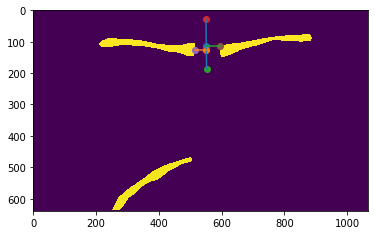

('17.88 %', None) 5_norm.png


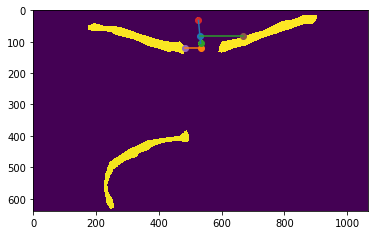

('63.21 %', None) 3_norm.png


In [22]:
for element in os.listdir('norm_mask/'):
    print ((collarbone_calculation('norm_mask/'+element)), element)

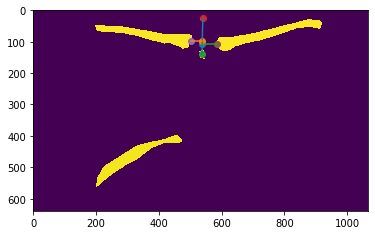

('23.54 %', None)

In [21]:
collarbone_calculation('1.png')

1custom.png


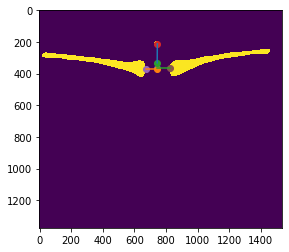

('13.96 %', None)
102_flurocustom.png


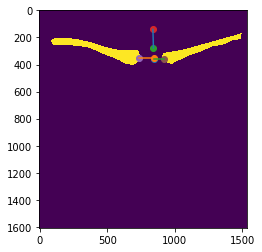

('29.44 %', None)
107_flurocustom.png


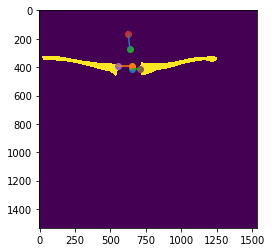

('36.86 %', None)
108_flurocustom.png


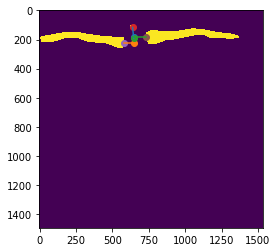

('17.84 %', None)
104_flurocustom.png


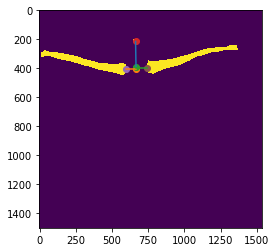

('13.61 %', None)
109_flurocustom.png


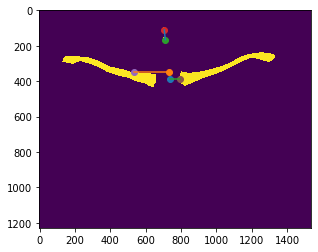

('69.14 %', None)
106_flurocustom.png


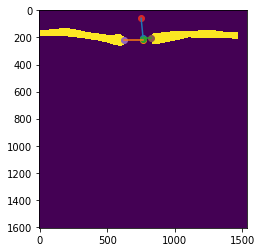

('56.23 %', None)
10_flurocustom.png


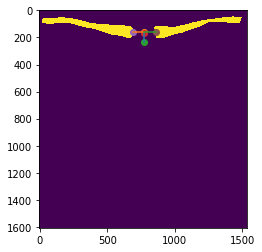

('5.75 %', None)
103_flurocustom.png


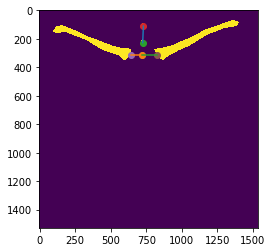

('20.95 %', None)
102_flurocustomcustom.png


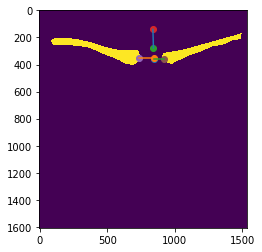

('29.44 %', None)


In [76]:
for element in os.listdir('mask/'):
    print (element)
    print (collarbone_calculation('mask/'+element))